### Kayla Hoffman 
### Github Username: kaylah176
### USC ID: 5610 8598 16

### Homework 3 - Time Series Classification 
### Part 1 - Feature Creation / Extraction

In [1]:
# Import libraries 
import glob 
import os 
import numpy as np 
import pandas as pd
import seaborn as sns

from scipy import stats 

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE 
from matplotlib import pyplot as plt
from scipy.stats import bootstrap
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler


a) Download the AReM data 

 b) The goal here is to keep datasets 1 and 2 in folders 'bending1' and 'bending2'. In addition, datasets 1, 2, and 3 are to be kept in other folders as test data and the rest of the datasets as training data. 

In [2]:
def data_split(folder_name, num_data_set, num_test_set):
    current_dir = os.getcwd()
    base_path = os.path.join(current_dir, 'AReM', folder_name)
    
    def read_csv(file_num):
        file_path = os.path.join(base_path, f'dataset{file_num}.csv')
        try:
            # Try reading the CSV with default settings
            return pd.read_csv(file_path, skiprows=4, error_bad_lines=False, warn_bad_lines=True)

        except pd.errors.ParserError:
            try:
                # If that fails, try reading with more flexible parsing
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    df = pd.read_csv(file_path, skiprows=4, error_bad_lines=False, warn_bad_lines=False)
                print(f"Note: Skipped some lines in {file_path}")
                return df
            except Exception as e:
                # If both methods fail, print an error message and return an empty DataFrame
                print(f"Error processing file {file_path}: {str(e)}")
                return pd.DataFrame()

    test_frame = pd.concat([df for df in (read_csv(i) for i in range(1, num_test_set + 1)) if not df.empty], ignore_index=True)
    train_frame = pd.concat([df for df in (read_csv(j) for j in range(num_test_set + 1, num_data_set + 1)) if not df.empty], ignore_index=True)
    
    return test_frame, train_frame


In [3]:
# Generate testing and training data from ARem folder
# Initialize list to store information
arem_testing = list()
arem_training = list()

# Deal with bending data first
bending = ["bending1", "bending2"]
arem_testing.append(data_split("bending1", 7, 2)[0])
arem_training.append(data_split("bending1", 7, 2)[1])
arem_testing.append(data_split("bending2", 6, 2)[0])
arem_training.append(data_split("bending2", 6, 2)[1])
    
# Deal with other data
other = ["cycling", "lying", "sitting", "standing", "walking"]
for folder in other:
    arem_testing.append(data_split(folder, 15, 3)[0])
    arem_training.append(data_split(folder, 15, 3)[1])
      
# Concatenate into testing and training dataframe
AREM_test = pd.concat(arem_testing, ignore_index=True)
AREM_train = pd.concat(arem_training, ignore_index=True)

Skipping line 485: expected 7 fields, saw 8

Skipping line 485: expected 7 fields, saw 8

Skipping line 485: expected 7 fields, saw 8

Skipping line 485: expected 7 fields, saw 8



In [4]:
# Check the dimensions
print("Testing set shape:", AREM_test.shape)
print("Training set shape:", AREM_train.shape)

Testing set shape: (9120, 7)
Training set shape: (33117, 7)


In [5]:
AREM_test.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,39.25,0.43,22.75,0.43,33.75,1.3
1,250,39.25,0.43,23.00,0.00,33.00,0.0
2,500,39.25,0.43,23.25,0.43,33.00,0.0
3,750,39.50,0.50,23.00,0.71,33.00,0.0
4,1000,39.50,0.50,24.00,0.00,33.00,0.0


In [6]:
AREM_train.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,42.00,0.71,21.25,0.43,30.00,0.00
1,250,41.50,0.50,20.25,1.48,31.25,1.09
2,500,41.50,0.50,14.25,1.92,33.00,0.00
3,750,40.75,0.83,15.75,0.43,33.00,0.00
4,1000,40.00,0.71,20.00,2.74,32.75,0.43


c) Feature Extraction 
Classification of time series data needs features extracted. In this problem we want to focus on time domain features.

i) According to this post ____ the following features can be used in time series classification. 
### Statistical Features 
1. Mean 
2. Standard deviation 
3. Skewness, Kurtosis 
4. Maximum and Minimum values 

### Time Series Features 
1. Cross Correlations between each dimension and the Auto-Correlations 
2. Order of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated ARIMA model 
3. Parameters of the AR part 
4. Parameters of the MA part

## ii 
Extract the time domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly 

In [7]:
def feature_extraction(folder_name, num_csv, num_test, l=1):
    current_dir = os.getcwd()
    base_path = os.path.join(current_dir, 'AReM', folder_name)

    train_csv = []
    test_csv = []

    extractions = []         
    features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
    series = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    
    global instance_cnt
    
    # Populate test_csv and train_csv lists
    for i in range(1, num_test + 1):
        file_path = os.path.join(base_path, f"dataset{i}.csv")
        test_csv.append(file_path)

    for i in range(num_test+1, num_csv+1):
        file_path = os.path.join(base_path, f"dataset{i}.csv")
        train_csv.append(file_path)

    # Process test CSV files
    for filename in test_csv:
        if not os.path.exists(filename):
            print(f"File not found: {filename}")
            continue
        
        try:
            df = pd.read_csv(filename, names=csv_header, skiprows=5, sep=',')
            
            temp = [instance_cnt]
            for series_name in series:
                series_stats = df[series_name].describe()
                for feature in features:
                    temp.append(series_stats[feature])
            
            # Include label indicating bending or not 
            temp.append(1 if folder_name.startswith(("bending1", "bending2")) else 0)
            
            # Include label for testing
            temp.append(1)
            
            extractions.append(temp)
            instance_cnt += 1
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")

    # Process train CSV files
    for filename in train_csv:
        if not os.path.exists(filename):
            print(f"File not found: {filename}")
            continue
        
        try:
            df = pd.read_csv(filename, skiprows=4)
            
            temp = [instance_cnt]
            for series_name in series:
                series_stats = df[series_name].describe()
                for feature in features:
                    temp.append(series_stats[feature])
            
            # Include label indicating bending or not 
            temp.append(1 if folder_name.startswith(("bending1", "bending2")) else 0)
            
            # Include label for training
            temp.append(0)
            
            extractions.append(temp)
            instance_cnt += 1
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
    
    return extractions

In [8]:
# Set serie names
series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series_formatname = [i for i in range(1, 7)]
# Set feature names to be extracted
features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
features_formatname = ['min', 'max', 'mean', 'median', 'std dev', '1st quart', '3rd quart']

# Initialize counting and list to store information
instance_cnt = 1
extracted_features = list()

# Iterate through csv in bending1 folder
extracted_features.extend(feature_extraction("bending1", 7, 2))
# Iterate through csv in bending1 folder
extracted_features.extend(feature_extraction("bending2", 6, 2))

other = ['cycling', 'lying', 'sitting', 'standing', 'walking']

# Iterate through other folders in ARem
for folder_name in other:
    extracted_features.extend(feature_extraction(folder_name, 15, 3))

Error processing file /Users/kaylahoffman/Desktop/AReM/bending1/dataset1.csv: name 'csv_header' is not defined
Error processing file /Users/kaylahoffman/Desktop/AReM/bending1/dataset2.csv: name 'csv_header' is not defined
Error processing file /Users/kaylahoffman/Desktop/AReM/bending2/dataset1.csv: name 'csv_header' is not defined
Error processing file /Users/kaylahoffman/Desktop/AReM/bending2/dataset2.csv: name 'csv_header' is not defined
Error processing file /Users/kaylahoffman/Desktop/AReM/cycling/dataset1.csv: name 'csv_header' is not defined
Error processing file /Users/kaylahoffman/Desktop/AReM/cycling/dataset2.csv: name 'csv_header' is not defined
Error processing file /Users/kaylahoffman/Desktop/AReM/cycling/dataset3.csv: name 'csv_header' is not defined
Error processing file /Users/kaylahoffman/Desktop/AReM/cycling/dataset9.csv: Error tokenizing data. C error: Expected 7 fields in line 485, saw 8

Error processing file /Users/kaylahoffman/Desktop/AReM/cycling/dataset14.csv: E

In [10]:
# Format column names for table
col = ['Instance']
for series_name in series_formatname:
    for feature in features_formatname:
        col.append(feature + "_" + str(series_name))

# Add "testing_label" only if it's not already included
if "testing_label" not in col:
    col.append("testing_label")
if "bending_label" not in col: 
    col.append("bending_label")

# Convert extracted information into dataframe
df_feature = pd.DataFrame(extracted_features)

# Ensure the number of columns matches
if len(df_feature.columns) < len(col):
    # Add missing columns with NaN values
    for i in range(len(df_feature.columns), len(col)):
        df_feature[f'column_{i}'] = np.nan
elif len(df_feature.columns) > len(col):
    # Truncate extra columns
    df_feature = df_feature.iloc[:, :len(col)]

# Assign the column names
df_feature.columns = col

display(df_feature)


,Instance,min_1,max_1,mean_1,median_1,std dev_1,1st quart_1,3rd quart_1,min_2,max_2,...,3rd quart_5,min_6,max_6,mean_6,median_6,std dev_6,1st quart_6,3rd quart_6,testing_label,bending_label
0,1,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,...,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,1,0
1,2,33.00,47.75,42.179812,43.50,3.670666,39.15,45.0000,0.0,3.00,...,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,1,0
2,3,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,...,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,1,0
3,4,37.00,48.00,43.454958,43.25,1.386098,42.50,45.0000,0.0,1.58,...,24.00,0.00,5.26,0.679646,0.50,0.622534,0.4300,0.8700,1,0
4,5,36.25,48.00,43.969125,44.50,1.618364,43.31,44.6700,0.0,1.50,...,23.75,0.00,2.96,0.555312,0.49,0.487826,0.0000,0.8300,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,63,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,...,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,0,0
63,64,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,...,17.75,0.00,9.67,3.432563,3.20,1.732727,2.1575,4.5650,0,0
64,65,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,...,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,0,0
65,66,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,...,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,0,0


iii) Estimate the standard deviation of each of the time domain features you extracted from the data. Then, use Python's bootstrap method or any other method to build a 90% bootstrap confidence interval for the standard deviation of each feature. 

In [15]:
# Drop the instnace and bending label because they are trivial for this part
df_feature_est = df_feature.loc[:, ~df_feature.columns.isin(["Instance", "bending_label", "testing_label"])]
col_est = col[1:-3]

# Estimate the standard deviation for each feature
df_std = df_feature_est.std()
display(df_std)

min_1          8.955680
max_1          4.246156
mean_1         4.879030
median_1       4.928231
std dev_1      1.778718
1st quart_1    5.745868
3rd quart_1    4.682491
min_2          0.000000
max_2          5.177672
mean_2         1.618695
median_2       1.455079
std dev_2      0.905419
1st quart_2    0.965805
3rd quart_2    2.182637
min_3          3.036929
max_3          4.699482
mean_3         3.843025
median_3       3.838507
std dev_3      1.016375
1st quart_3    4.135884
3rd quart_3    3.942657
min_4          0.000000
max_4          2.289299
mean_4         1.171571
median_4       1.145013
std dev_4      0.465259
1st quart_4    0.840724
3rd quart_4    1.551683
min_5          5.382833
max_5          5.559671
mean_5         5.214054
median_5       5.367637
std dev_5      1.052480
1st quart_5    5.641968
3rd quart_5    5.056108
min_6          0.052929
max_6          2.515308
mean_6         1.159504
median_6       1.098421
std dev_6      0.508721
1st quart_6    0.770075
3rd quart_6    1

In [17]:
def impute_for_std(df_feature_est):
    # Calculate median and IQR for each column
    medians = df_feature_est.median()
    q1 = df_feature_est.quantile(0.25)
    q3 = df_feature_est.quantile(0.75)
    iqr = q3 - q1

    # Define lower and upper bounds for valid data
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Create a copy of the data for imputation
    imputed_data = df_feature_est.copy()

    for column in df_feature_est.columns:
        # Identify outliers and missing values
        mask = (df_feature_est[column] < lower_bound[column]) | (df_feature_est[column] > upper_bound[column]) | df_feature_est[column].isna()

        # Impute outliers and missing values with median
        imputed_data.loc[mask, column] = medians[column]

    return imputed_data


# Apply the imputation
df_imputed = impute_for_std(df_feature_est)

# Calculate standard deviation
std_dev = df_imputed.std()

# Calculate 90% confidence interval for standard deviation
n = len(df_imputed)
ci_lower = std_dev * np.sqrt((n - 1) / stats.chi2.ppf(0.95, n - 1))
ci_upper = std_dev * np.sqrt((n - 1) / stats.chi2.ppf(0.05, n - 1))

# Create a dataframe with results
df_results = pd.DataFrame({
    'Feature': std_dev.index,  # Get feature names from the index
    'Standard Deviation': std_dev.values,  # Get std values
    'CI Lower': ci_lower.values,
    'CI Upper': ci_upper.values
})

print(df_results)


        Feature  Standard Deviation  CI Lower  CI Upper
0         min_1            8.093834  7.091950  9.460815
1         max_1            2.473889  2.167662  2.891708
2        mean_1            4.842028  4.242664  5.659806
3      median_1            4.891068  4.285634  5.717129
4     std dev_1            1.765195  1.546693  2.063322
5   1st quart_1            5.707984  5.001429  6.672015
6   3rd quart_1            4.649649  4.074099  5.434936
7         min_2            0.000000  0.000000  0.000000
8         max_2            5.143037  4.506414  6.011653
9        mean_2            1.611093  1.411666  1.883193
10     median_2            1.447544  1.268362  1.692022
11    std dev_2            0.900747  0.789249  1.052876
12  1st quart_2            0.959385  0.840629  1.121418
13  3rd quart_2            2.174133  1.905011  2.541326
14        min_3            3.014275  2.641157  3.523361
15        max_3            3.115492  2.729845  3.641672
16       mean_3            2.094908  1.835593  2

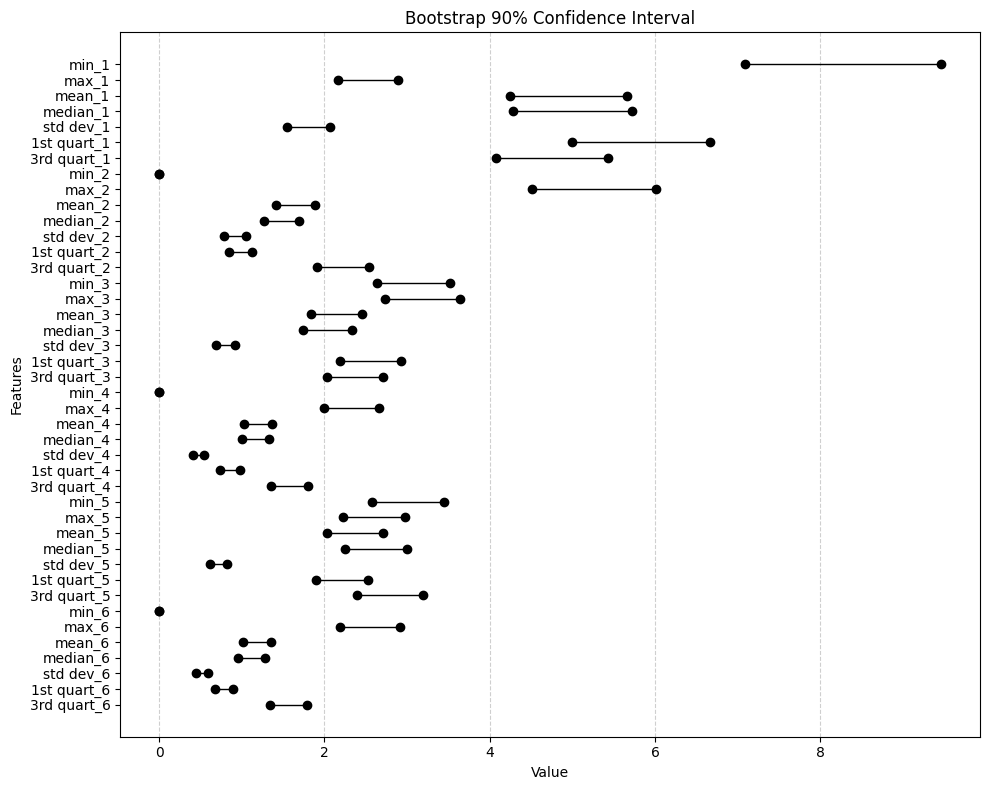

In [18]:
plt.figure(figsize=(10, 8))

# Plot the confidence intervals
plt.hlines(y=df_results['Feature'], xmin=df_results['CI Lower'], xmax=df_results['CI Upper'], color="black", linewidth=1)

# Plot circle markers at the CI limits
plt.plot(df_results['CI Lower'], df_results['Feature'], "o", color="black")
plt.plot(df_results['CI Upper'], df_results['Feature'], "o", color="black")

# Customize the plot
plt.xlabel('Value')
plt.ylabel('Features')
plt.title('Bootstrap 90% Confidence Interval')

# Invert the y-axis
plt.gca().invert_yaxis()

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### iv) Use your judgement to select the three most important time-domain features (one option could be min, mean, and max)

The three most important time-domain features that I determined are mean, median, and standard deviation. 

The graph above shows that the feature standard deviation is a small value of the estimated values, even when other features have a large confidence interval or estimated value. Choosing mean and median would be more accurate for our future classification model. 

However, even the feature 'min' has a small value for the confidence intervals, such as the confidence interval of some min features is (0,0) and same with the estimated standard deviation of min. Our goal for the classification model is to include more flexibility thus, we choose not to pick feature min. 

### References 
scipy.stats.bootstrap 

Determining Features for Time Series Classification: https://stats.stackexchange.com/questions/50807/features-for-time-series-classification#:~:text=Usually%20the%20features%20used%20to,than%20being%20features%20in%20themselves.

Time Series classification based on statistical features: https://jwcn-eurasipjournals.springeropen.com/articles/10.1186/s13638-020-1661-4


## Homework 4 Starts Here

### 2) Time Series Classification Part 2: Binary and Multiclass Classification 
#### a) Binary Classification Using Logistic Regression

In [19]:
df_feature.head()

,Instance,min_1,max_1,mean_1,median_1,std dev_1,1st quart_1,3rd quart_1,min_2,max_2,...,3rd quart_5,min_6,max_6,mean_6,median_6,std dev_6,1st quart_6,3rd quart_6,testing_label,bending_label
0,1,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,...,36.50,0.0,1.79,0.493292,0.43,0.513506,0.00,0.94,1,0
1,2,33.00,47.75,42.179812,43.50,3.670666,39.15,45.00,0.0,3.00,...,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00,1,0
2,3,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,...,31.25,0.0,1.79,0.383292,0.43,0.389164,0.00,0.50,1,0
3,4,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,1.58,...,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87,1,0
4,5,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,1.50,...,23.75,0.0,2.96,0.555312,0.49,0.487826,0.00,0.83,1,0


In [20]:
# Get training data from dataframe
df_feature_train = df_feature.loc[df_feature["testing_label"] == 0]
print(df_feature_train.shape)

(58, 45)


In [21]:
df_feature_est.head()

,min_1,max_1,mean_1,median_1,std dev_1,1st quart_1,3rd quart_1,min_2,max_2,mean_2,...,std dev_5,1st quart_5,3rd quart_5,min_6,max_6,mean_6,median_6,std dev_6,1st quart_6,3rd quart_6
0,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.00,0.94
1,33.00,47.75,42.179812,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00
2,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.00,0.50
3,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87
4,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.75,0.0,2.96,0.555312,0.49,0.487826,0.00,0.83


## a) Binary Classification Using Logistic Regresson 
i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the feature you specificed in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities

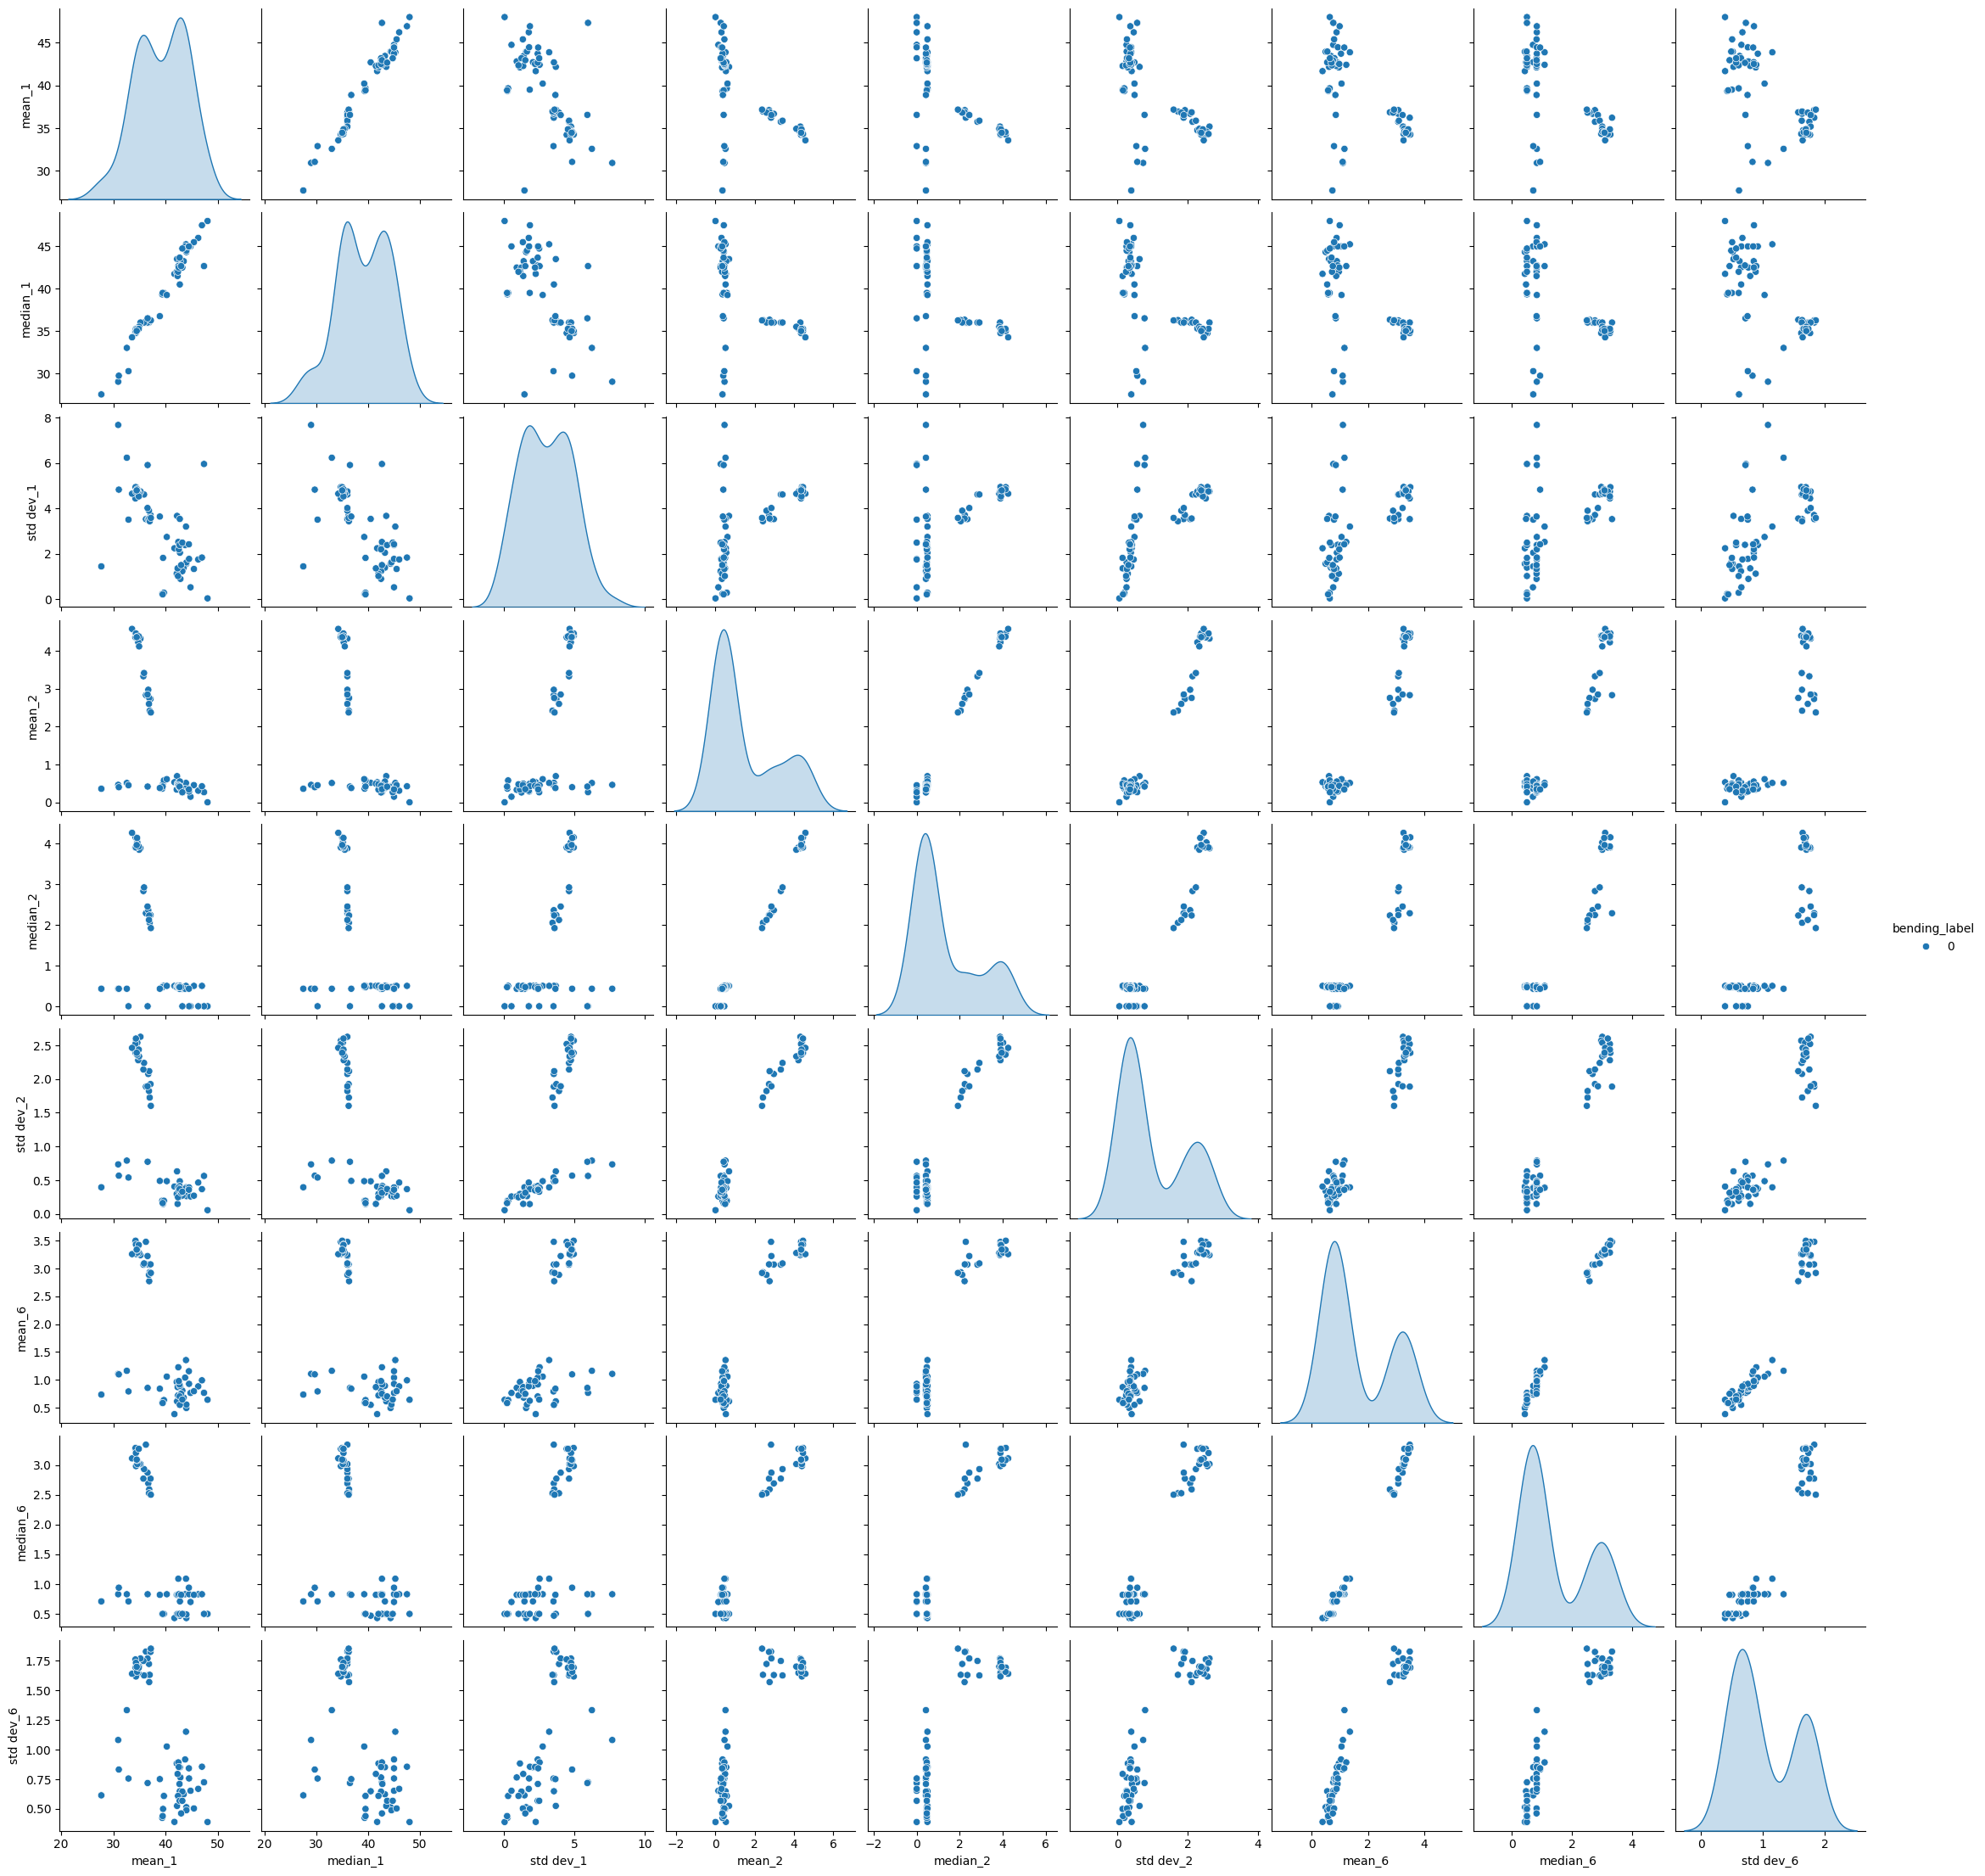

In [22]:
# Define series we are interested in
series_names = [1, 2, 6]
# Define features we are interested in
features_formatname = ['mean', 'median', 'std dev']

# Format column names we are interested in
col_sub = []
for series_name in series_names:
    for feature in features_formatname:
        col_sub.append(feature + "_" + str(series_name))
col_sub.append("bending_label")

# Extract data for scatter plot
df_feature_126 = df_feature[col_sub]

# Plot pair plots
sns.pairplot(df_feature_126, hue="bending_label")
plt.show()

## ii)
 Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training, instance. Repeat the experiment in 2(a)i depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [23]:
# Select first half of dataframe and reset index
df_first_half = df_feature_126.iloc[:len(df_feature)//2].reset_index(drop=True)

# Rename the columns
new_columns = [f"{col}_1" if col != "bending_label" else col for col in df_first_half.columns]
df_first_half.columns = new_columns

# Fill the NaNs in row six with the mean of the column 
df_first_half = df_first_half.fillna(df_first_half.mean())

# display(df_first_half)

In [25]:
# Select second half of dataframe, reset index, and remove last column
df_second_half = df_feature_126.iloc[len(df_feature)//2:-1].reset_index(drop=True).iloc[:, :-1]

# Rename the columns
new_columns = [f"{col}_2" for col in df_second_half.columns]
df_second_half.columns = new_columns

# display(df_second_half)

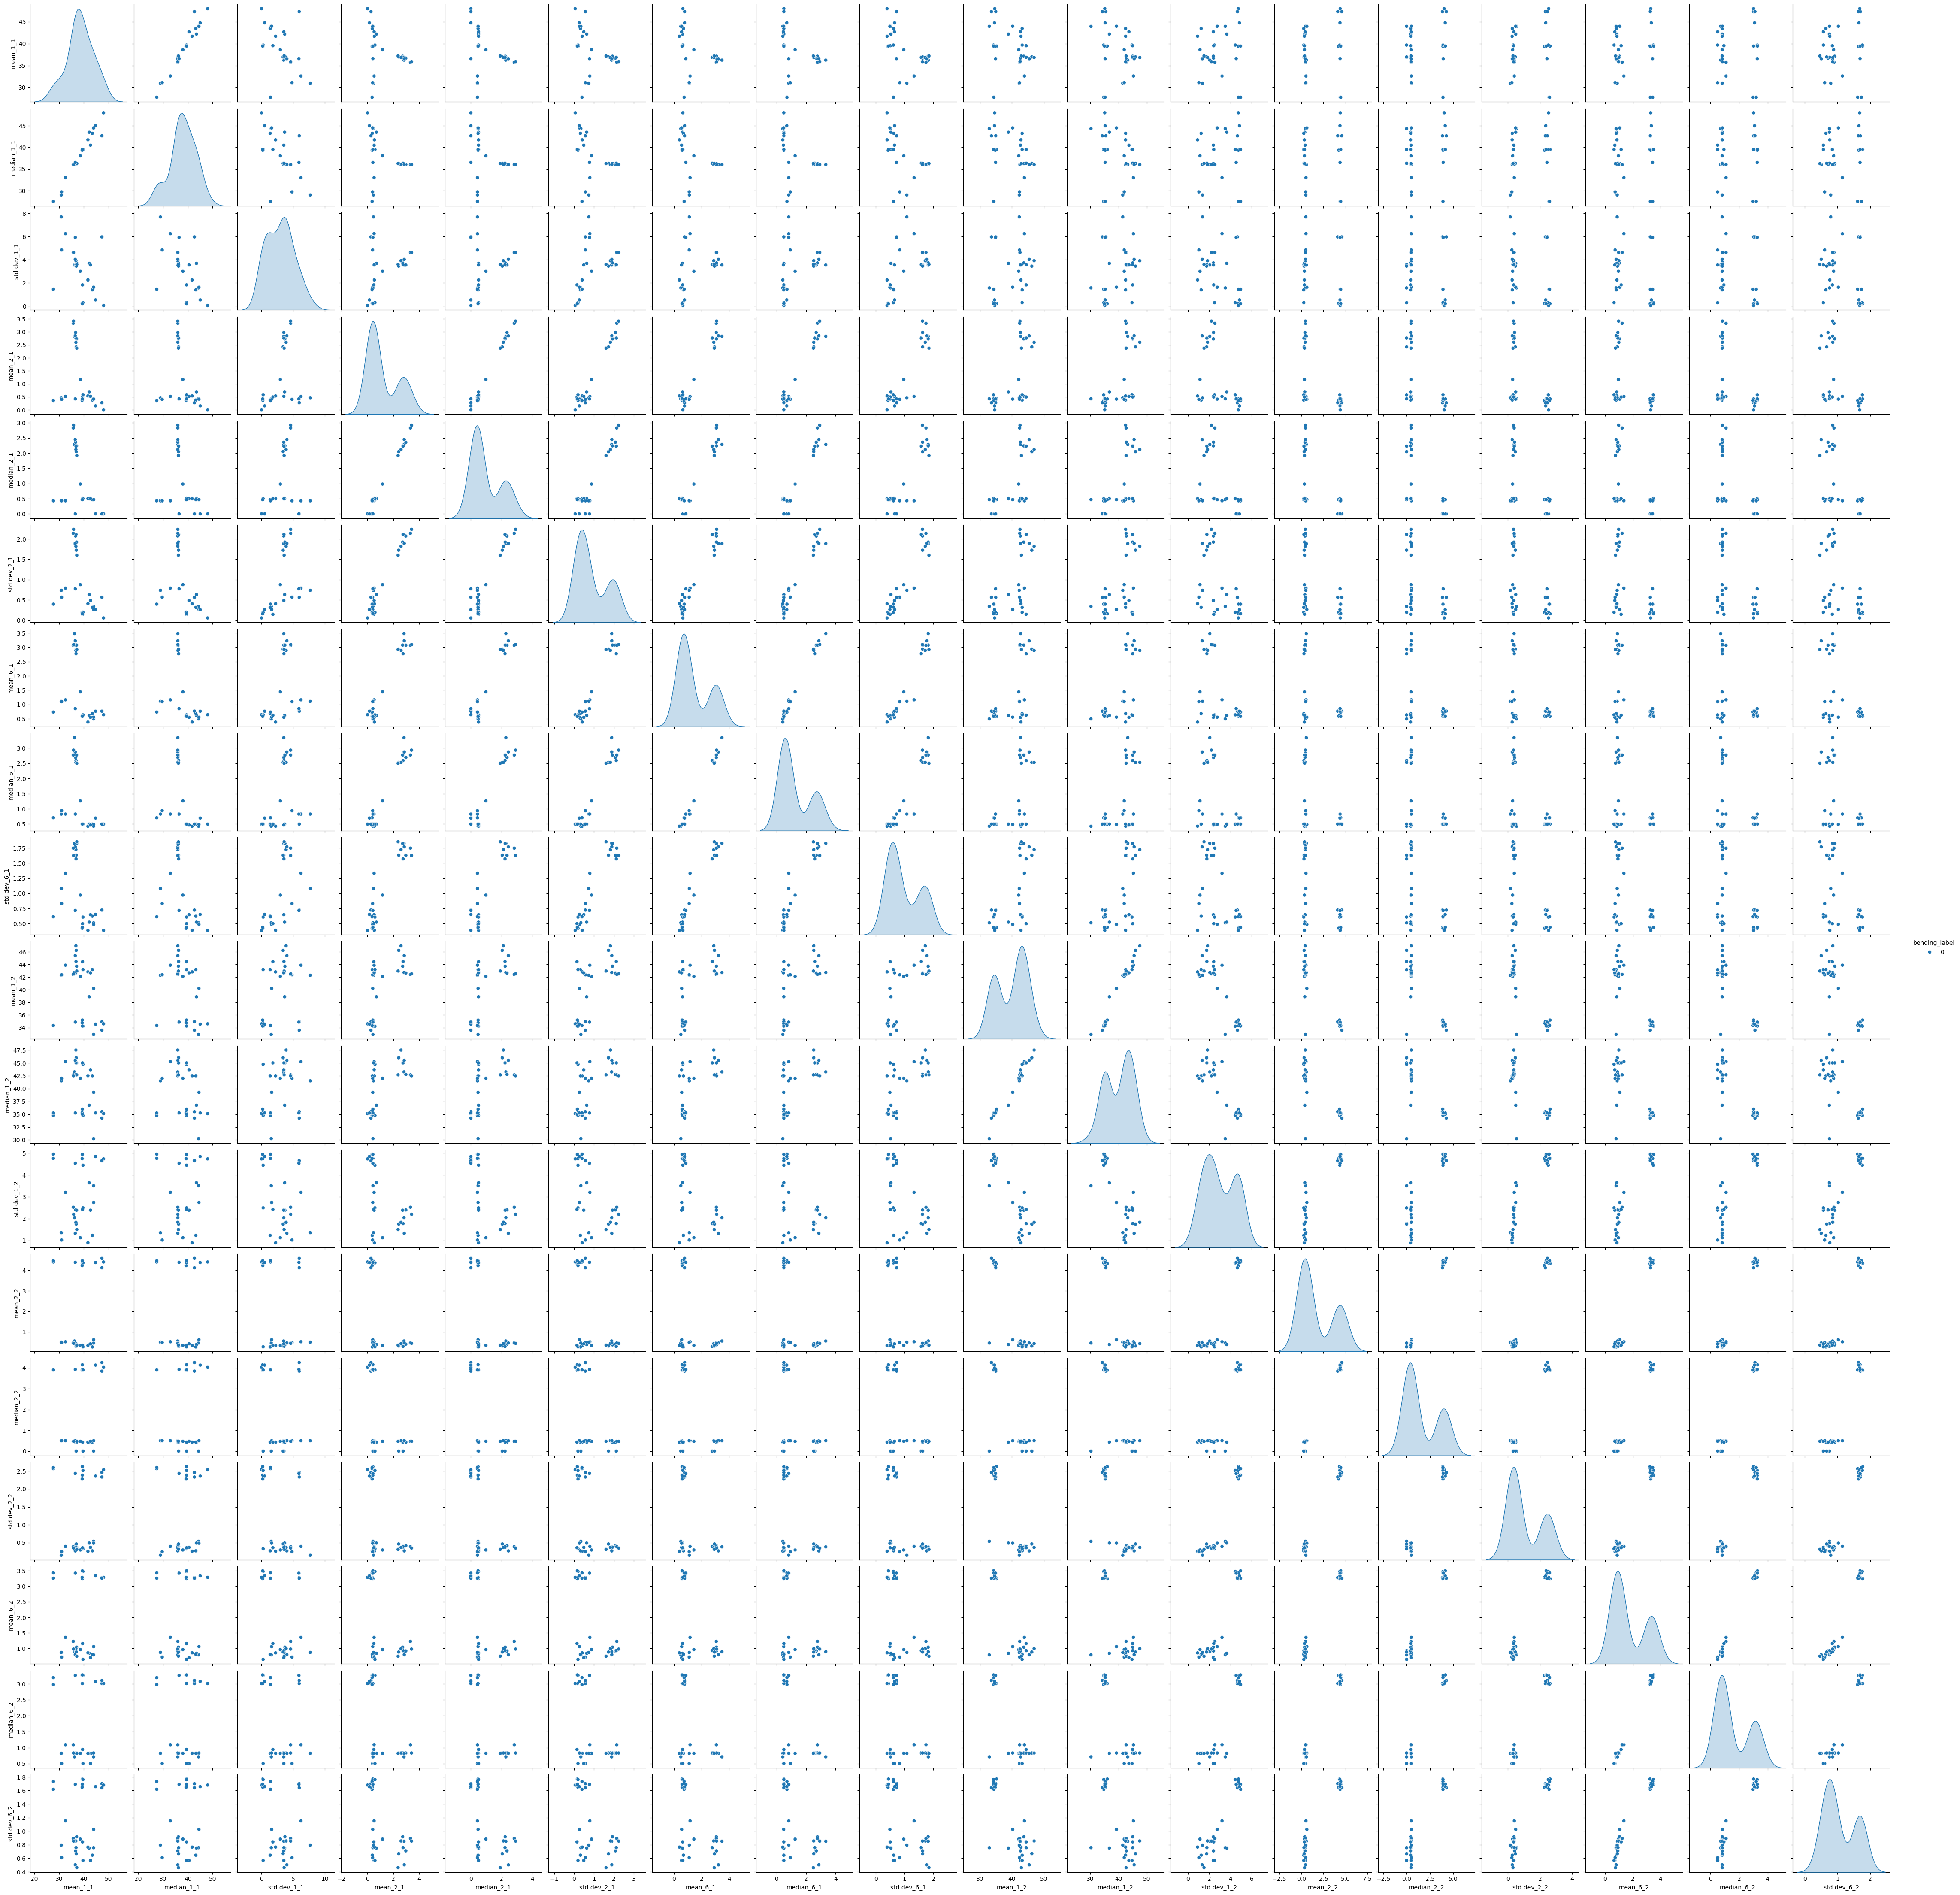

In [26]:
# Concatenate into a new dataframe 
df_break_feature = pd.concat([df_first_half, df_second_half], axis=1)
# display(df_break_feature)

# Plot pair plots
sns.pairplot(df_break_feature, hue="bending_label")
plt.show()

When we divide each time series in the training set into two approximately equal sets, there is a clearer pattern for classification. From the plot above we can now see boundaries between bending and other activities, while in part 2(a)i we found it hard to distinguish them. 

### iii) 
Break each time series in your training set into l {1,2,...,20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of 
 and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l,p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.
 

### Recursive Feature Elimination code

In [42]:
def important_feature_extraction(FolderName, num_csv, num_test, l=5):
    global instance_cnt # Access the global instance counter

    # Initialize lists to hold file paths
    train_csv = []
    test_csv = []
    feature_extraction = []

    # Get the current working directory
    current_dir = os.getcwd()
    base_path = os.path.join(current_dir, 'ARem', FolderName) #Removed data folder

    # Populate test_csv and train_csv lists
    for i in range(1, num_test + 1):
        file_path = os.path.join(base_path, f"dataset{i}.csv") #Path set correctly
        test_csv.append(file_path)

    for i in range(num_test + 1, num_csv + 1):
        file_path = os.path.join(base_path, f"dataset{i}.csv") #Path set correctly
        train_csv.append(file_path)

    # List to hold extractions from all files
    feature_extractions = list()

    # --- Process test CSV files ---
    for filename in test_csv:
        file_path = os.path.join('ARem', FolderName, filename)
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        df = pd.read_csv(filename, names=csv_header, skiprows=5, on_bad_lines='skip')
        df = df.drop("time", axis=1)

        # Split dataframe into sub dataframe according to L = number of partition
        # df_split is a list of sub dataframe
        df_split = np.array_split(df, l)

        split_info = list()  # Initialize a list to hold information for the single dataframe, i.e. csv

        # For each sub dataframe, find mean, median, and std dev
        for df_sub in df_split:
            sub_df_info = list()  # Initialize a list to hold information for each sub dataframe
            for series_name in series:
                for feature in features:
                    # Obtain statistics in the order of mean, median and std dev
                    sub_df_info.append(df_sub.describe()[series_name][feature])

            split_info.extend(sub_df_info)  # Add dataframe into info list

         # Include label indicating bending or not 
        if (FolderName == "bending1") or (FolderName == "bending2"):
            split_info.append(str(1))
        else:
            split_info.append(str(0))

        # Include label for testing
        split_info.append(str(1))

        # Concatenate statistics for all splits 
        df_concat_info = pd.DataFrame(split_info).transpose()
        feature_extraction.append(df_concat_info)


    # --- Process train CSV files ---
    for filename in train_csv:
        file_path = os.path.join('ARem', FolderName, filename)
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        df = pd.read_csv(filename, names=csv_header, skiprows=5, on_bad_lines='skip')
        df = df.drop("time", axis=1)

        # Split dataframe into sub dataframe according to L = number of partition
        # df_split is a list of sub dataframe
        df_split = np.array_split(df, l)

        split_info = list()  # Initialize a list to hold information for the single dataframe, i.e. csv

        # For each sub dataframe, find mean, median, and std dev
        for df_sub in df_split:
            sub_df_info = list()  # Initialize a list to hold information for each sub dataframe
            for series_name in series:
                for feature in features:
                    # Obtain statistics in the order of mean, median and std dev
                    sub_df_info.append(df_sub.describe()[series_name][feature])

            split_info.extend(sub_df_info)  # Add dataframe into info list

        # Include label indicating bending or not 
        if (FolderName == "bending1") or (FolderName == "bending2"):
            split_info.append(1)
        else:
            split_info.append(0)

        # Include label for training
        split_info.append(0)

        # Concatenate statistics for all splits 
        df_concat_info = pd.DataFrame(split_info).transpose()
        feature_extraction.append(df_concat_info)

    return feature_extraction

In [43]:
# Define some information
csv_header = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series_formatname = [i for i in range(1, 7)]

# Set feature names to be extracted
features = ['mean', '50%', 'std']
features_formatname = ['mean', 'median', 'std dev']

In [70]:
df_LR_train.dropna(inplace=True)
df_LR_train.head()

,mean_1_1,median_1_1,std dev_1_1,mean_2_1,median_2_1,std dev_2_1,mean_3_1,median_3_1,std dev_3_1,mean_4_1,median_4_1,std dev_4_1,mean_5_1,median_5_1,std dev_5_1,mean_6_1,median_6_1,std dev_6_1,bending_label,testing_label
2,43.9545,44.33,1.558835,0.42625,0.47,0.33869,22.122354,23.0,3.030943,0.497312,0.43,0.550657,35.588458,36.0,1.999604,0.493292,0.43,0.513506,1,0.0
3,42.179812,43.5,3.670666,0.696042,0.5,0.63086,22.183625,23.0,3.810469,0.989917,0.83,0.95373,33.493917,35.0,3.849448,0.613521,0.5,0.524317,1,0.0
4,41.678063,41.75,2.24349,0.535979,0.5,0.405469,19.006563,19.125,4.087107,0.841875,0.5,0.928801,29.857083,30.0,2.411026,0.383292,0.43,0.389164,1,0.0
5,43.454958,43.25,1.386098,0.378083,0.47,0.315566,15.793333,15.0,3.847638,0.849354,0.5,0.995761,23.034792,23.5,2.488862,0.679646,0.5,0.622534,1,0.0
6,43.969125,44.5,1.618364,0.413125,0.47,0.263111,15.868021,16.25,3.74242,0.666354,0.47,0.788985,22.10375,21.67,3.318301,0.555312,0.49,0.487826,1,0.0


In [82]:
# Define the size of time series in training set
TimeSeries_size = [i for i in range(1, 21)]
max_l = max(TimeSeries_size)

# Prepare full dataset once
column_name = []
for i in range(1, max_l+1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(f"{feature}_{series_name}_{i}")

column_name.extend(["bending_label", "testing_label"])

important_feature = []
important_feature.extend(important_feature_extraction("bending1", 7, 2, max_l))
important_feature.extend(important_feature_extraction("bending2", 6, 2, max_l))
for folder_name in other:
    important_feature.extend(important_feature_extraction(folder_name, 15, 3, max_l))

# Make dataframe for all information extracted
df_full = pd.concat(important_feature, axis=0, ignore_index=True)
df_full.columns = column_name

# Convert to numeric values and drop NaNs once
df_full = df_full.apply(pd.to_numeric, errors='coerce')
df_full["bending_label"] = df_full["bending_label"].astype('int')
print(f"NaNs before dropping: {df_full.isnull().sum().sum()}")
df_full.dropna(inplace=True)
print(f"NaNs after dropping: {df_full.isnull().sum().sum()}")

# Save Logistics model evaluation result
plist = []
score = []

# Iterate through all sizes and train Logistic Regression model
# Iterate through all sizes and train Logistic Regression model
for l in TimeSeries_size:
    # Select columns for current time series size
    current_columns = [
        col for col in df_full.columns 
        if col in ["bending_label", "testing_label"] or (col.split('_')[-1].isdigit() and int(col.split('_')[-1]) <= l)
    ]
    df_current = df_full[current_columns]

    # Get training data
    df_LR_train = df_current[df_current['testing_label'] == 0]

    # Define model input
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:, -2]

    # Fit Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    
    # Fit RFECV model
    rfecv = RFECV(estimator=model, cv=StratifiedKFold(5), scoring='accuracy')
    rfecv.fit(X_train, Y_train)

    # Report progress
    print(f"Optimal number of features for l = {l} is {rfecv.n_features_}")
    print(f"Cross-validation score: {np.max(rfecv.cv_results_['mean_test_score'])}")

    plist.append(rfecv.n_features_)
    score.append(np.max(rfecv.cv_results_['mean_test_score']))

print("Feature selection complete.")

NaNs before dropping: 360
NaNs after dropping: 0
Optimal number of features for l = 1 is 3
Cross-validation score: 0.956043956043956
Optimal number of features for l = 2 is 1
Cross-validation score: 0.9846153846153847
Optimal number of features for l = 3 is 1
Cross-validation score: 0.9846153846153847
Optimal number of features for l = 4 is 1
Cross-validation score: 0.9846153846153847
Optimal number of features for l = 5 is 1
Cross-validation score: 0.9846153846153847
Optimal number of features for l = 6 is 2
Cross-validation score: 0.9846153846153847
Optimal number of features for l = 7 is 2
Cross-validation score: 0.9846153846153847
Optimal number of features for l = 8 is 2
Cross-validation score: 0.9846153846153847
Optimal number of features for l = 9 is 2
Cross-validation score: 0.9846153846153847
Optimal number of features for l = 10 is 2
Cross-validation score: 0.9846153846153847
Optimal number of features for l = 11 is 2
Cross-validation score: 0.9846153846153847
Optimal number 

In [83]:
# Display best (l, p) pair along with p-value
df_bestp = pd.DataFrame({"l": TimeSeries_size, "p-features": plist, "Score":score})
df_bestp.index = np.arange(1, 21)
# Sort dataframe based on CV-score and l
df_bestp = df_bestp.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_bestp.to_string(index=False))

 l  p-features    Score
 2           1 0.984615
 3           1 0.984615
 4           1 0.984615
 5           1 0.984615
 6           2 0.984615
 7           2 0.984615
 8           2 0.984615
 9           2 0.984615
10           2 0.984615
11           2 0.984615
12           2 0.984615
13           2 0.984615
14           2 0.984615
15           2 0.984615
16           2 0.984615
18           1 0.984615
17           1 0.969231
19           1 0.969231
20           1 0.969231
 1           3 0.956044


In the above cell, we sorted the dataframe by CV score in descending order. Our goal is to find the smalest l values with the highest CV score. However, in this case, the highest CV score is associated with l=1 and p-features=1. This indicates overfitting and that the model is memorizing the training data instead of learning generalizable patterns. A possible solution to this is using K-Fold CV with l=5 or l=10 to ensure each partition is validated against multiple splits. However, I changed l=1 to l=5 and seemed to still get an overfitting issue. 

The wrong way to cross validate would be to perform feature selection on the entire dataset before cross-validation. This would lead to data leakage and biased results, 

### iv. 
Report the confusion matrix and show the ROC and AUC for your classifier on the training data. Report the parameters of you logistic regression βi's as well as the p-values associated with them. 

In [91]:
l = 10

# Format column names
column_name = []
for i in range(1, l + 1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(f"{feature}_{series_name}_{i}")
# Add bending_label and testing_label to column names
column_name.extend(["bending_label", "testing_label"])

important_feature = []
# Iterate through bending1 folder
important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
# Iterate through bending2 folder
important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
# Iterate through other folders in ARem
for folder_name in other:
    important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))

# Make dataframe for all information extracted
df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)

# Set column names accordingly
df_important_feature.columns = column_name

# Convert to numeric values (coerce errors to NaN)
df_important_feature = df_important_feature.apply(pd.to_numeric, errors="coerce")

# Ensure bending_label is an integer
df_important_feature["bending_label"] = df_important_feature["bending_label"].astype("int")

# Drop rows with NaN values (handle missing data)
print(f"NaNs before dropping: {df_important_feature.isnull().sum().sum()}")
df_important_feature.dropna(inplace=True)
print(f"NaNs after dropping: {df_important_feature.isnull().sum().sum()}")

# Get training data (only rows where testing_label == 0)
df_LR_train = df_important_feature.loc[df_important_feature["testing_label"] == 0]

# Define model input
X_train = df_LR_train.iloc[:, :-2]
Y_train = df_LR_train.iloc[:, -2]


NaNs before dropping: 180
NaNs after dropping: 0


In [92]:
# Declare Logistic Regression model
model_train = LogisticRegression(solver='liblinear')
# Train model based on value obtained above
rfe = RFE(model_train, n_features_to_select=10)
# Fit model on training data
rfe.fit(X_train, Y_train)
# Make prediction based on model above
y_pred = rfe.predict(X_train)

model_CM = confusion_matrix(Y_train, y_pred)
print("CONFUSION MATRIX")
print(model_CM)
cols = list(X_train.columns[rfe.support_])

CONFUSION MATRIX
[[60  0]
 [ 0  8]]


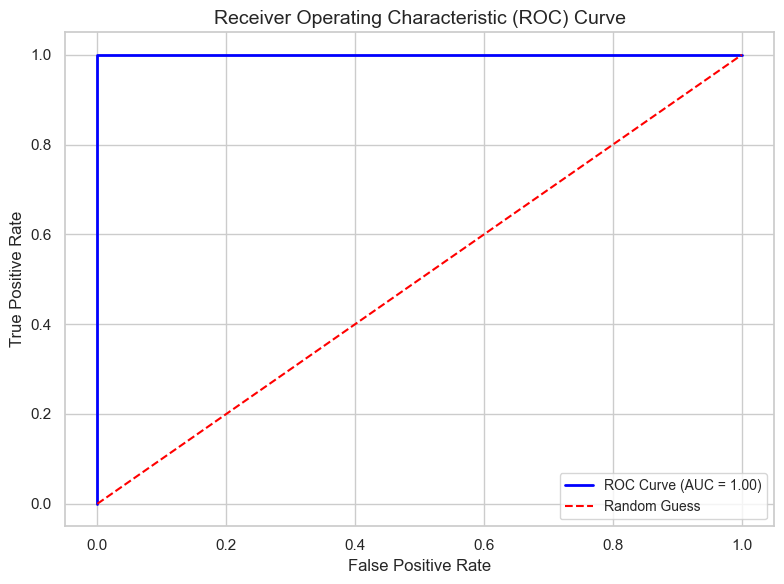

In [93]:
# Calculate ROC AUC score
rfe_score = roc_auc_score(Y_train, y_pred)

# Calculate FPR (False Positive Rate) and TPR (True Positive Rate)
fpr, tpr, thresholds = roc_curve(Y_train, rfe.predict_proba(X_train)[:, 1])

# Use Seaborn for improved aesthetics
sns.set(style="whitegrid")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {rfe_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=1.5, label='Random Guess')

# Add gridlines and labels
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [97]:
# Report the estimated parameters and p-values accordingly
X_train_new = X_train[cols]
logit_model_selected = sm.Logit(Y_train, X_train_new)
model_selected = logit_model_selected.fit(method = 'lbfgs')
print(model_selected.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.52741D+01

At iterate    1    f=  5.45251D-01    |proj g|=  3.71755D+00

At iterate    2    f=  4.40039D-01    |proj g|=  2.71876D+00

At iterate    3    f=  3.53213D-01    |proj g|=  1.35432D+00

At iterate    4    f=  3.30149D-01    |proj g|=  2.55922D+00

At iterate    5    f=  2.95339D-01    |proj g|=  2.71031D+00

At iterate    6    f=  1.50911D-01    |proj g|=  1.75117D+00

At iterate    7    f=  9.86324D-02    |proj g|=  8.75321D-01

At iterate    8    f=  5.49273D-02    |proj g|=  3.35974D-01

At iterate    9    f=  3.13838D-02    |proj g|=  1.39184D-01

At iterate   10    f=  1.72763D-02    |proj g|=  7.14687D-02

At iterate   11    f=  9.42947D-03    |proj g|=  5.82034D-02

At iterate   12    f=  5.12192D-03    |proj g|=  4.20337D-02

At iterate   13    f=  2.7

 This problem is unconstrained.


The summary of the logistic regression shows up that there is a quasi-separation problem which means that the classes are too well separated. The predictor variables are so good at distinguishing between classes that they almost perfectly predict the outcome for a large portion of the observations. The majority of the p-value for all estimators are between 0.998 - 1.000 > α = 0.05. This means we would have to fail to reject the null hypothesis that βi = 0. The estimators are statistically insignificant, due to perfect class seperation. 

This causes a problem for out model's fit because the logistic regression algorithm struggles to estimate finite coefficients when the separation is nearly perfect. 

## v. 
Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [98]:
# Get testing set
df_LR_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

# Define model input
X_test = df_LR_test.iloc[:, :-2]
Y_test = df_LR_test.iloc[:,-2:-1]

# Fit logistic model
model_test = LogisticRegression(solver='liblinear')
rfe = RFE(model_test, n_features_to_select=10)
rfe.fit(X_test, Y_test.values.ravel())
y_pred_test = rfe.predict(X_test)
print("Cross-validation score:", rfe.score(X_test, Y_test))

Cross-validation score: 1.0


## vi. 
Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters? 

Yes, the near perfect class separation (indicated by the p-values almost equal to 1) seems to be causing instability in calculating logistic regression parameters. 

## vii. 
From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model 

From the confusion matrices, we see that we have high true positive and low true negative. We have larger cost on the true positive side. Thus, we will build logistic regression model based on case-control sampling.

In [103]:
# Use SMOTE package to resample data
smote = SMOTE(random_state=2, k_neighbors=1)
# Resample the data
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

parameters = {'C': np.linspace(1, 10, 10)}

# Refit the model
model_lr = LogisticRegression()
gs= GridSearchCV(mod_lr, parameters, cv=5)
gs.fit(X_train_smote, Y_train_smote)

model_lr = LogisticRegression(C = gs.best_params_.get('C'))
model_lr.fit(X_train_smote, Y_train_smote)
y_train_pre = model_lr.predict(X_train)

# Display confusion matrix
confusion_matrix_resampled = confusion_matrix(Y_train, y_train_pre)
print("CONFUSION MATRIX")
print(confusion_matrix_resampled)

CONFUSION MATRIX
[[39  0]
 [ 0  4]]


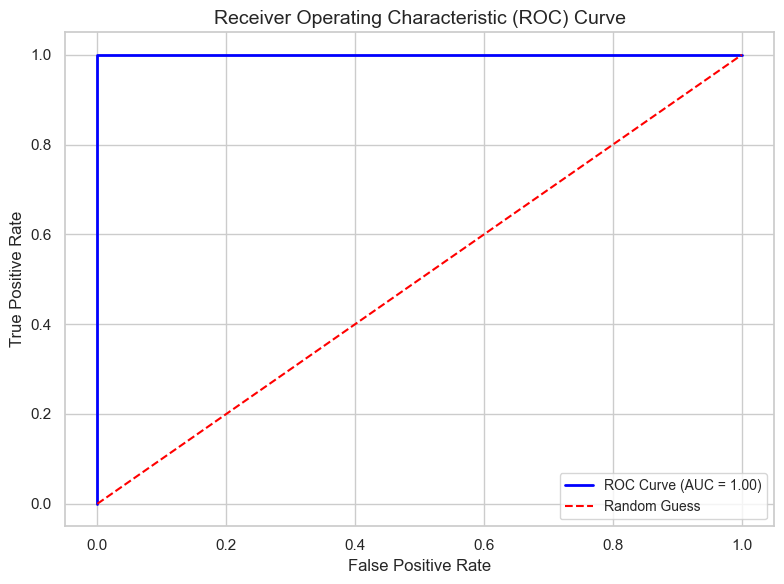

In [105]:
# Calculate ROC AUC score
rfe_score = roc_auc_score(Y_train, y_train_pre)

# Calculate FPR (False Positive Rate) and TPR (True Positive Rate)
fpr, tpr, thresholds = roc_curve(Y_train, model_lr.predict_proba(X_train)[:, 1])

# Use Seaborn for improved aesthetics
sns.set(style="whitegrid")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {rfe_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=1.5, label='Random Guess')

# Add gridlines and labels
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### b) Binary Classification Using L1-penalized logistic regression

## i.
Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [106]:
# Iterate through all sizes and train Logistic Regression model
for l in TimeSeries_size:
    current_columns = [
        col for col in df_full.columns 
        if col in ["bending_label", "testing_label"] or 
        (col.split('_')[-1].isdigit() and int(col.split('_')[-1]) <= l)
    ]
    df_current = df_full[current_columns]
    df_LR_train = df_current[df_current['testing_label'] == 0]
    
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:, -2]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Fit L1-penalized model with CV-tuned regularization
    model = LogisticRegressionCV(
        penalty='l1', 
        solver='liblinear',
        Cs=np.logspace(-4, 4, 20),
        cv=5,
        max_iter=5000
    )
    model.fit(X_train_scaled, Y_train)
    
    # Record results
    n_selected = sum(model.coef_[0] != 0)
    plist.append(n_selected)
    score.append(model.score(X_train_scaled, Y_train))
    
    print(f"l={l}: Selected {n_selected} features | Accuracy: {score[-1]:.2f}")


l=1: Selected 4 features | Accuracy: 0.97
l=2: Selected 4 features | Accuracy: 0.99
l=3: Selected 5 features | Accuracy: 0.99
l=4: Selected 5 features | Accuracy: 0.99
l=5: Selected 7 features | Accuracy: 0.99
l=6: Selected 9 features | Accuracy: 0.99
l=7: Selected 13 features | Accuracy: 1.00
l=8: Selected 9 features | Accuracy: 0.99
l=9: Selected 9 features | Accuracy: 0.99
l=10: Selected 9 features | Accuracy: 0.99
l=11: Selected 9 features | Accuracy: 0.99
l=12: Selected 10 features | Accuracy: 0.99
l=13: Selected 10 features | Accuracy: 0.99
l=14: Selected 10 features | Accuracy: 0.99
l=15: Selected 11 features | Accuracy: 1.00
l=16: Selected 5 features | Accuracy: 0.97
l=17: Selected 66 features | Accuracy: 1.00
l=18: Selected 9 features | Accuracy: 1.00
l=19: Selected 14 features | Accuracy: 1.00
l=20: Selected 16 features | Accuracy: 1.00


In [109]:
l = 2

# Format column names
column_name = []
for i in range(1, l + 1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(f"{feature}_{series_name}_{i}")
# Add bending_label and testing_label to column names
column_name.extend(["bending_label", "testing_label"])

important_feature = []
# Iterate through bending1 folder
important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
# Iterate through bending2 folder
important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
# Iterate through other folders in ARem
for folder_name in other:
    important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))

# Make dataframe for all information extracted
df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)

# Set column names accordingly
df_important_feature.columns = column_name

# Convert to numeric values (coerce errors to NaN)
df_important_feature = df_important_feature.apply(pd.to_numeric, errors="coerce")

# Ensure bending_label is an integer
df_important_feature["bending_label"] = df_important_feature["bending_label"].astype("int")

# Drop rows with NaN values (handle missing data)
print(f"NaNs before dropping: {df_important_feature.isnull().sum().sum()}")
df_important_feature.dropna(inplace=True)
print(f"NaNs after dropping: {df_important_feature.isnull().sum().sum()}")

# Get training data (only rows where testing_label == 0)
df_LR_train = df_important_feature.loc[df_important_feature["testing_label"] == 0]

# Define model input
X_train = df_LR_train.iloc[:, :-2]
Y_train = df_LR_train.iloc[:, -2]


NaNs before dropping: 36
NaNs after dropping: 0


In [110]:
# Declare Logistic Regression model
model_train = LogisticRegression(solver='liblinear')
# Train model based on value obtained above
rfe = RFE(model_train, n_features_to_select=5)
# Fit model on training data
rfe.fit(X_train, Y_train)
# Make prediction based on model above
y_pred = rfe.predict(X_train)
# Obtain columns selected
cols = list(X_train.columns[rfe.support_])

# Report the estimated parameters and p-values accordingly
X_train_new = X_train[cols]
logit_model_selected = sm.Logit(Y_train, X_train_new)
model_selected = logit_model_selected.fit(method = 'lbfgs')
print(model_selected.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.74865D+00

At iterate    1    f=  6.87868D-01    |proj g|=  2.49125D+00

At iterate    2    f=  5.39853D-01    |proj g|=  1.68862D+00

At iterate    3    f=  4.76660D-01    |proj g|=  2.24060D-01

At iterate    4    f=  4.66622D-01    |proj g|=  2.94742D-01

At iterate    5    f=  4.26196D-01    |proj g|=  1.11001D+00

At iterate    6    f=  3.65134D-01    |proj g|=  1.74677D+00

At iterate    7    f=  2.94098D-01    |proj g|=  1.16550D+00

At iterate    8    f=  2.48689D-01    |proj g|=  5.28646D-01

At iterate    9    f=  2.28927D-01    |proj g|=  1.88330D-01

At iterate   10    f=  2.21575D-01    |proj g|=  2.76639D-02

At iterate   11    f=  2.19546D-01    |proj g|=  2.84465D-02

At iterate   12    f=  2.18683D-01    |proj g|=  3.90154D-02

At iterate   13    f=  2.1

 This problem is unconstrained.
/Users/kaylahoffman/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We can see that for this model with L1-penalized logistic regression it performs better and only perfectly predicts 37% of observations. This is due to the penalty term being based on the absolute value of the model coefficients, which helps to prevent overfitting and perform automatic feature selection. 

# c) Multi-class Classification (The Realistic Case)

## i. 
Find the best in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [111]:
def important_feature_extraction(FolderName, num_csv, num_test, l=5):
    global instance_cnt # Access the global instance counter

    # Initialize lists to hold file paths
    train_csv = []
    test_csv = []
    feature_extraction = []

    # Get the current working directory
    current_dir = os.getcwd()
    base_path = os.path.join(current_dir, 'ARem', FolderName) #Removed data folder

    # Populate test_csv and train_csv lists
    for i in range(1, num_test + 1):
        file_path = os.path.join(base_path, f"dataset{i}.csv") #Path set correctly
        test_csv.append(file_path)

    for i in range(num_test + 1, num_csv + 1):
        file_path = os.path.join(base_path, f"dataset{i}.csv") #Path set correctly
        train_csv.append(file_path)

    # List to hold extractions from all files
    feature_extractions = list()

    # --- Process test CSV files ---
    for filename in test_csv:
        file_path = os.path.join('ARem', FolderName, filename)
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        df = pd.read_csv(filename, names=csv_header, skiprows=5, on_bad_lines='skip')
        df = df.drop("time", axis=1)

        # Split dataframe into sub dataframe according to L = number of partition
        # df_split is a list of sub dataframe
        df_split = np.array_split(df, l)

        split_info = list()  # Initialize a list to hold information for the single dataframe, i.e. csv

        # For each sub dataframe, find mean, median, and std dev
        for df_sub in df_split:
            sub_df_info = list()  # Initialize a list to hold information for each sub dataframe
            for series_name in series:
                for feature in features:
                    # Obtain statistics in the order of mean, median and std dev
                    sub_df_info.append(df_sub.describe()[series_name][feature])

            split_info.extend(sub_df_info)  # Add dataframe into info list

         # Include label indicating bending or not 
        if (FolderName == "bending1") or (FolderName == "bending2"):
            split_info.append(str(1))
        else:
            split_info.append(str(0))

        # Include label for testing
        split_info.append(str(1))

        # Concatenate statistics for all splits 
        df_concat_info = pd.DataFrame(split_info).transpose()
        feature_extraction.append(df_concat_info)


    # --- Process train CSV files ---
    for filename in train_csv:
        file_path = os.path.join('ARem', FolderName, filename)
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        df = pd.read_csv(filename, names=csv_header, skiprows=5, on_bad_lines='skip')
        df = df.drop("time", axis=1)

        # Split dataframe into sub dataframe according to L = number of partition
        # df_split is a list of sub dataframe
        df_split = np.array_split(df, l)

        split_info = list()  # Initialize a list to hold information for the single dataframe, i.e. csv

        # For each sub dataframe, find mean, median, and std dev
        for df_sub in df_split:
            sub_df_info = list()  # Initialize a list to hold information for each sub dataframe
            for series_name in series:
                for feature in features:
                    # Obtain statistics in the order of mean, median and std dev
                    sub_df_info.append(df_sub.describe()[series_name][feature])

            split_info.extend(sub_df_info)  # Add dataframe into info list

        # Include label indicating bending or not 
        if (FolderName == "bending1") or (FolderName == "bending2"):
            split_info.append(1)
        else:
            split_info.append(0)

        # Include label for training
        split_info.append(0)

        # Concatenate statistics for all splits 
        df_concat_info = pd.DataFrame(split_info).transpose()
        feature_extraction.append(df_concat_info)

    return feature_extraction

In [122]:
# Initialize lists to store results
TimeSeries_size_completed = []
plist = []
score = []

# Iterate through all sizes and train Logistic Regression model
for l in TimeSeries_size:
    current_columns = [
        col for col in df_full.columns 
        if col in ["bending_label", "testing_label"] or 
        (col.split('_')[-1].isdigit() and int(col.split('_')[-1]) <= l)
    ]
    df_current = df_full[current_columns]
    df_LR_train = df_current[df_current['testing_label'] == 0]
    
    # Define model input
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:,-2:-1]
    
    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Grid search for best C value
    parameters = {'C': np.linspace(1, 10, 10)}
    mod_lr = LogisticRegression(penalty='l1', solver='saga', multi_class='ovr')
    clf = GridSearchCV(mod_lr, parameters, cv=5)
    clf.fit(X_train_scaled, Y_train.values.ravel())

    # Feature selection using best C value
    best_C = clf.best_params_['C']
    sel_ = SelectFromModel(LogisticRegression(C=1/best_C, 
                                              penalty='l1', 
                                              solver='saga',
                                              multi_class='ovr'))
    sel_.fit(X_train_scaled, Y_train.values.ravel())
    
    # Get number of selected features
    n_selected = sum(sel_.get_support())
    
    # Record results
    TimeSeries_size_completed.append(l)
    plist.append(n_selected)
    score.append(clf.best_score_)

    
    print(f"l={l}: Selected {n_selected} features | C={best_C:.2f} | Accuracy: {clf.best_score_:.2f}")

print("Feature selection complete.")


l=1: Selected 7 features | C=1.00 | Accuracy: 0.96
l=2: Selected 7 features | C=2.00 | Accuracy: 0.97
l=3: Selected 9 features | C=2.00 | Accuracy: 0.98
l=4: Selected 13 features | C=1.00 | Accuracy: 0.97
l=5: Selected 12 features | C=2.00 | Accuracy: 0.97
l=6: Selected 13 features | C=2.00 | Accuracy: 0.97
l=7: Selected 26 features | C=1.00 | Accuracy: 0.99
l=8: Selected 27 features | C=1.00 | Accuracy: 0.97
l=9: Selected 30 features | C=1.00 | Accuracy: 0.99
l=10: Selected 32 features | C=1.00 | Accuracy: 0.97
l=11: Selected 34 features | C=1.00 | Accuracy: 0.97
l=12: Selected 41 features | C=1.00 | Accuracy: 0.97
l=13: Selected 39 features | C=1.00 | Accuracy: 0.97
l=14: Selected 42 features | C=1.00 | Accuracy: 0.97
l=15: Selected 43 features | C=1.00 | Accuracy: 0.98
l=16: Selected 46 features | C=1.00 | Accuracy: 0.98
l=17: Selected 47 features | C=1.00 | Accuracy: 0.93
l=18: Selected 48 features | C=1.00 | Accuracy: 0.93
l=19: Selected 53 features | C=1.00 | Accuracy: 0.88
l=20:

In [123]:
# Create DataFrame only with completed iterations
df_bestp = pd.DataFrame({
    "l": TimeSeries_size_completed, 
    "p-features": plist, 
    "Score": score
})
df_bestp.index = range(1, len(df_bestp) + 1)

# Display the DataFrame
print(df_bestp)

     l  p-features     Score
1    1           7  0.956044
2    2           7  0.970330
3    3           9  0.984615
4    4          13  0.970330
5    5          12  0.970330
6    6          13  0.971429
7    7          26  0.985714
8    8          27  0.970330
9    9          30  0.985714
10  10          32  0.970330
11  11          34  0.970330
12  12          41  0.970330
13  13          39  0.970330
14  14          42  0.970330
15  15          43  0.984615
16  16          46  0.984615
17  17          47  0.927473
18  18          48  0.926374
19  19          53  0.883516
20  20          54  0.883516


The (l, p) that gives us the best model is (1,7)

In [126]:
l = 1

# Format column names
column_name = []
for i in range(1, l + 1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(f"{feature}_{series_name}_{i}")
# Add bending_label and testing_label to column names
column_name.extend(["bending_label", "testing_label"])

important_feature = []
# Iterate through bending1 folder
important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
# Iterate through bending2 folder
important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
# Iterate through other folders in ARem
for folder_name in other:
    important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))

# Make dataframe for all information extracted
df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)

# Set column names accordingly
df_important_feature.columns = column_name

# Convert to numeric values (coerce errors to NaN)
df_important_feature = df_important_feature.apply(pd.to_numeric, errors="coerce")

# Ensure bending_label is an integer
df_important_feature["bending_label"] = df_important_feature["bending_label"].astype("int")

# Drop rows with NaN values (handle missing data)
print(f"NaNs before dropping: {df_important_feature.isnull().sum().sum()}")
df_important_feature.dropna(inplace=True)
print(f"NaNs after dropping: {df_important_feature.isnull().sum().sum()}")

# Get training data (only rows where testing_label == 0)
df_LR_train = df_important_feature.loc[df_important_feature["testing_label"] == 0]

# Define model input
X_train = df_LR_train.iloc[:, :-2]
Y_train = df_LR_train.iloc[:, -2]


NaNs before dropping: 18
NaNs after dropping: 0


In [127]:
# Declare Multiclass Logistic Regression model
model_train = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')
# Train model based on value obtained above
rfe = RFE(model_train, n_features_to_select=14)
# Fit model on training data
rfe.fit(X_train, Y_train)

# Obtain testing data
df_LR_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

# Define X_Test and Y_Test 
X_test = df_LR_test.iloc[:, :-2]
Y_test = df_LR_test.iloc[:,-2:-1]

# Find model score
model_score = rfe.score(X_test, Y_test)
# Report model error
print("Test error :", 1-model_score)

Test error : 0.0


In [128]:
# Initialize lists to store results
TimeSeries_size_completed = []
plist = []
score = []

# Iterate through all sizes and train Naive Bayes model
for l in TimeSeries_size:
    current_columns = [
        col for col in df_full.columns 
        if col in ["bending_label", "testing_label"] or 
        (col.split('_')[-1].isdigit() and int(col.split('_')[-1]) <= l)
    ]
    df_current = df_full[current_columns]
    df_LR_train = df_current[df_current['testing_label'] == 0]
    
    # Define model input
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:,-2:-1]
    
    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Feature selection using Logistic Regression (L1-penalized)
    mod_lr = LogisticRegression(penalty='l1', solver='saga', multi_class='ovr', max_iter=1000, C=1.0)
    sel_ = SelectFromModel(mod_lr)
    sel_.fit(X_train_scaled, Y_train.values.ravel())
    
    # Select features
    selected_features = sel_.get_support()
    X_train_selected = X_train_scaled[:, selected_features]
    
    # Train Naive Bayes classifier on selected features
    nb_model = GaussianNB()
    cv_scores = cross_val_score(nb_model, X_train_selected, Y_train.values.ravel(), cv=5)
    
    # Record results
    n_selected = sum(selected_features)
    TimeSeries_size_completed.append(l)
    plist.append(n_selected)
    score.append(cv_scores.mean())
    
    print(f"l={l}: Selected {n_selected} features | Cross-Validation Accuracy: {cv_scores.mean():.2f}")

print("Feature selection and Naive Bayes training complete.")

l=1: Selected 7 features | Cross-Validation Accuracy: 0.90
l=2: Selected 3 features | Cross-Validation Accuracy: 0.90
l=3: Selected 7 features | Cross-Validation Accuracy: 0.93
l=4: Selected 9 features | Cross-Validation Accuracy: 0.93
l=5: Selected 10 features | Cross-Validation Accuracy: 0.93
l=6: Selected 11 features | Cross-Validation Accuracy: 0.93
l=7: Selected 11 features | Cross-Validation Accuracy: 0.93
l=8: Selected 11 features | Cross-Validation Accuracy: 0.93
l=9: Selected 12 features | Cross-Validation Accuracy: 0.93
l=10: Selected 13 features | Cross-Validation Accuracy: 0.93
l=11: Selected 14 features | Cross-Validation Accuracy: 0.93
l=12: Selected 15 features | Cross-Validation Accuracy: 0.93
l=13: Selected 15 features | Cross-Validation Accuracy: 0.93
l=14: Selected 16 features | Cross-Validation Accuracy: 0.93
l=15: Selected 18 features | Cross-Validation Accuracy: 0.93
l=16: Selected 19 features | Cross-Validation Accuracy: 0.91
l=17: Selected 19 features | Cross-Va

In [129]:
# Display best l result by find the best score
df_bestp = pd.DataFrame({"l": TimeSeries_size, "Score":score})
df_bestp.index = np.arange(1, 21)
# Sort dataframe based on score
df_bestp = df_bestp.sort_values(by="Score", ascending=False)
print(df_bestp.to_string(index=False))

 l    Score
18 0.942857
19 0.928571
20 0.928571
 4 0.927473
12 0.927473
11 0.927473
 3 0.927473
 5 0.927473
 9 0.927473
 6 0.927473
 7 0.927473
 8 0.927473
14 0.927473
15 0.927473
10 0.927473
13 0.927473
16 0.914286
17 0.914286
 1 0.898901
 2 0.898901


In [131]:
# Initialize lists to store results
TimeSeries_size_completed = []
plist = []
score = []

# Iterate through all sizes and train Multinomial Naive Bayes model
for l in TimeSeries_size:
    current_columns = [
        col for col in df_full.columns 
        if col in ["bending_label", "testing_label"] or 
        (col.split('_')[-1].isdigit() and int(col.split('_')[-1]) <= l)
    ]
    df_current = df_full[current_columns]
    df_LR_train = df_current[df_current['testing_label'] == 0]
    
    # Define model input
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:,-2:-1]
    
    # Preprocessing: StandardScaler for feature selection, MinMaxScaler for MultinomialNB
    std_scaler = StandardScaler()
    X_train_std = std_scaler.fit_transform(X_train)

    # Feature selection using Logistic Regression (L1-penalized)
    mod_lr = LogisticRegression(penalty='l1', solver='saga', multi_class='ovr', max_iter=1000, C=1.0)
    sel_ = SelectFromModel(mod_lr)
    sel_.fit(X_train_std, Y_train.values.ravel())
    
    # Select features
    selected_features = sel_.get_support()
    X_train_selected = X_train.iloc[:, selected_features]
    
    # Apply MinMaxScaler to selected features (MultinomialNB requires non-negative features)
    minmax_scaler = MinMaxScaler()
    X_train_minmax = minmax_scaler.fit_transform(X_train_selected)
    
    # Train Multinomial Naive Bayes classifier on selected features
    mnb_model = MultinomialNB()
    cv_scores = cross_val_score(mnb_model, X_train_minmax, Y_train.values.ravel(), cv=5)
    
    # Record results
    n_selected = sum(selected_features)
    TimeSeries_size_completed.append(l)
    plist.append(n_selected)
    score.append(cv_scores.mean())
    
    print(f"l={l}: Selected {n_selected} features | Cross-Validation Accuracy: {cv_scores.mean():.2f}")

print("Feature selection and Multinomial Naive Bayes training complete.")


l=1: Selected 7 features | Cross-Validation Accuracy: 0.88
l=2: Selected 3 features | Cross-Validation Accuracy: 0.88
l=3: Selected 7 features | Cross-Validation Accuracy: 0.88
l=4: Selected 9 features | Cross-Validation Accuracy: 0.88
l=5: Selected 10 features | Cross-Validation Accuracy: 0.88
l=6: Selected 11 features | Cross-Validation Accuracy: 0.88
l=7: Selected 11 features | Cross-Validation Accuracy: 0.88
l=8: Selected 11 features | Cross-Validation Accuracy: 0.88
l=9: Selected 12 features | Cross-Validation Accuracy: 0.88
l=10: Selected 13 features | Cross-Validation Accuracy: 0.88
l=11: Selected 14 features | Cross-Validation Accuracy: 0.88
l=12: Selected 15 features | Cross-Validation Accuracy: 0.88
l=13: Selected 15 features | Cross-Validation Accuracy: 0.88
l=14: Selected 16 features | Cross-Validation Accuracy: 0.88
l=15: Selected 18 features | Cross-Validation Accuracy: 0.88
l=16: Selected 19 features | Cross-Validation Accuracy: 0.90
l=17: Selected 19 features | Cross-Va

In [132]:
# Display best l result by find the best score
df_bestp = pd.DataFrame({"l": TimeSeries_size, "Score":score})
df_bestp.index = np.arange(1, 21)
# Sort dataframe based on score
df_bestp = df_bestp.sort_values(by="Score", ascending=False)
print(df_bestp.to_string(index=False))

 l    Score
18 0.912088
19 0.912088
20 0.912088
16 0.897802
17 0.897802
 3 0.883516
 2 0.883516
 1 0.883516
 4 0.883516
 5 0.883516
 7 0.883516
 6 0.883516
12 0.883516
11 0.883516
10 0.883516
 9 0.883516
 8 0.883516
15 0.883516
13 0.883516
14 0.883516


### iii) Which method is better for multiclass classification in this problem? 
In the problem that involves multi class classification, we see that the Bayes classifier with Multinomila priors obtained the best testing result. 


## ISLR Chapter 4.8.3
We know the posterior probability of the Baye's classifier is given by

$$
p_k(x) = \frac{\pi_k \frac{1}{\sqrt{2 \pi} \sigma_k} \exp\big({-\frac{1}{2 \sigma_k^2} (x-\mu_k)^2}\big)}
        { \sum_{l=1}^{k}\pi_l \frac{1}{\sqrt{2 \pi} \sigma_l} \exp\big({-\frac{1}{2 \sigma_l^2} (x-\mu_l)^2}\big)}
$$

where we want to the maximum of a class. To do so, we see that we want to maximize the log function.

## ISLR Chapter 4.8.7 
We identify that $\pi_{YES} = 0.8$, and we know that $\pi_{No} = 0.2$. Then we want to plug numbers into the probability function

$$
\begin{align*}
p_{yes}(4) 
    &= \frac{0.8 \exp\big({-\frac{1}{2 \cdot 36} (4 - 10)^2}\big)}
        {0.8 \exp\big({-\frac{1}{2 \cdot 36} (4 - 10)^2}\big) + 0.2 \exp\big({-\frac{1}{2 \cdot 36} (4 - 0)^2}\big)} \\
    &= 0.75
\end{align*}
$$

## References 
[Features for time series classification](https://stats.stackexchange.com/questions/50807/features-for-time-series-classification#:~:text=Usually%20the%20features%20used%20to,than%20being%20features%20in%20themselves.)

[Import multiple CSV files into pandas and concatenate into one DataFrame](https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe)

[`scipy.stats.bootstrap`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html)

[`sklearn.feature_selection.RFECV`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

[`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[`sklearn.naive_bayes.GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

[SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

[Time series classification based on statistical features](https://jwcn-eurasipjournals.springeropen.com/articles/10.1186/s13638-020-1661-4)